# Regresión Lineal usando Ecuaciones Normales

___

## Introducción

Los modelos de regresión lineal son un buen punto de partida para las tareas de regresión y para entender varios conceptos. En este notebook, implementaremos regresión lineal desde cero, usando métodos y operaciones básicas con arreglos de numpy.

## Importación de bibliotecas

Comencemos con las importaciones de bibliotecas estándar:

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Generación del conjunto de datos

Antes de iniciar con las implementación, generaremos un conjunto de datos. Para simplificar las cosas, construiremos un conjunto de datos artificial. Nuestra tarea será recuperar los parámetros de este modelo utilizando el conjunto finito de ejemplos contenidos en nuestro conjunto de datos. Mantendremos los datos de dimensiones reducidas para que podamos visualizarlos fácilmente.

En el siguiente fragmento de código, generamos un conjunto de datos que contiene 1000 muestras, cada uno de los cuales consta de 1 característica extraída de una distribución normal estándar. Por lo tanto, nuestro conjunto de datos sintéticos será una matriz $\mathbf{X}\in \mathbb{R}^{1000 \times 1}$.

In [ ]:
def synthetic_data(w, b, num_examples):
  """Generar y = Xw + b + noise."""
  X = np.random.randn(num_examples, len(w)) * 2
  y = np.matmul(X, w) + b #Xw+b
  y += np.random.randn(*y.shape)
  return X, y.reshape(-1, 1)

Los verdaderos parámetros que generan nuestro conjunto de datos serán
$\mathbf{w} = [1.5]^\top$ y $b = 4.2$:

In [ ]:
true_w = np.array([1.5])
true_b = 4.2
X, y = synthetic_data(true_w, true_b, 1200)

Declaramos a $\mathbf{w}$ como un vector ya que nos permitirá generalizar el modelo a más de una característica. Ahora, visualicemos la data generada:

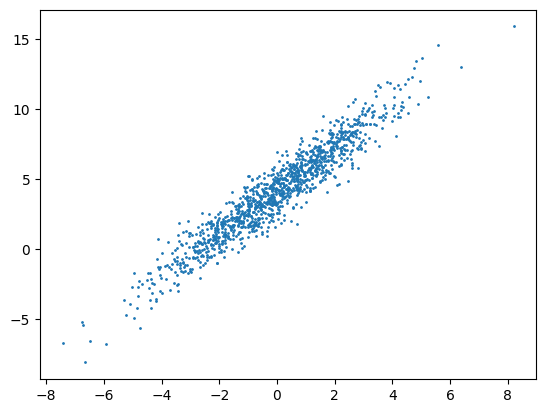

In [ ]:
plt.scatter(X, y, 1)

Podemos observar claramente la relación lineal entre la data de entrada y el valor objetivo.

## Particionamiento de datos

Particionaremos los datos de tal forma que los últimos $200$ serán para la data de prueba y los primeros $1000$ para la data de entrenamiento. En este ejemplo simple no consideraremos data de validación. En ejercicios futuros si haremos el particionamiento considerando data de validación.

In [ ]:
def data_split(X, y, train_size):
  # TODO: Particionar la data de tal forma que los primeros elementos
  #       dados por train_size formen parte de la data de entrenamiento
  #       y el resto forme parte de la data de prueba
  X_train, y_train = X[:train_size], y[:train_size]
  X_test, y_test = X[train_size:], y[train_size:]

  return X_train, y_train, X_test, y_test

In [ ]:
print(X.shape, y.shape)

(1200, 1) (1200, 1)


In [ ]:
X_train, y_train, X_test, y_test = data_split(X, y, 1000)
print("Tamano de la data de entrenamiento:", X_train.shape, y_train.shape)
print("Tamano de la data de prueba:", X_test.shape, y_test.shape)

Tamano de la data de entrenamiento: (1000, 1) (1000, 1)
Tamano de la data de prueba: (200, 1) (200, 1)


<ipython-input-8-b6b2a5f1cfdb>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


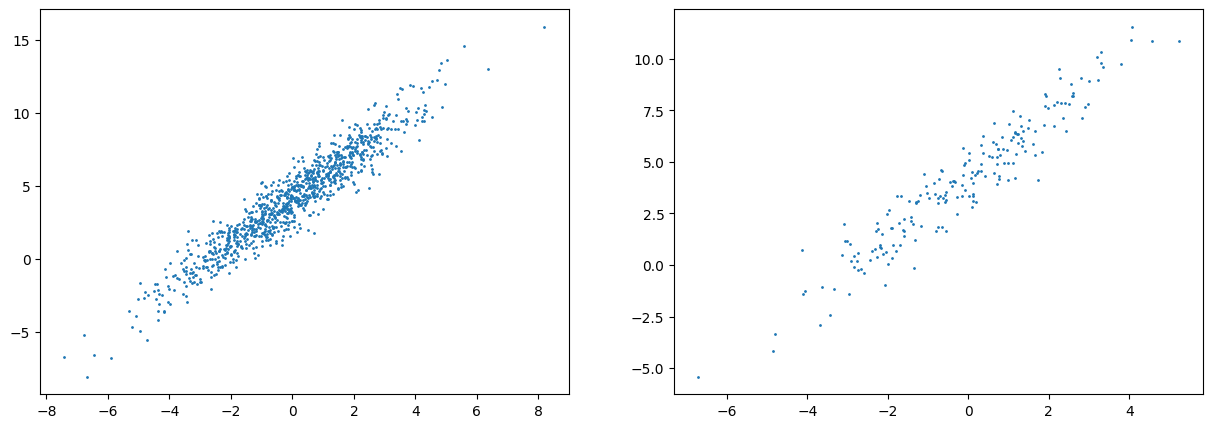

In [ ]:
plt.subplots(figsize =(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_train, y_train, 1)
plt.subplot(1, 2, 2)
plt.scatter(X_test, y_test, 1)
plt.show()

## Regresión Lineal desde cero

En esta sección implementaremos todo el método desde cero, incluyendo el modelo, la función de pérdida y el optimizador de gradiente descendente. Si bien los frameworks de deep learning modernos pueden automatizar casi todo este trabajo, implementar las cosas desde cero es la única forma de asegurarnos de que realmente sabemos lo que estamos haciendo.

Además, cuando llega el momento de personalizar modelos, definir nuestras propias capas o funciones de pérdida, comprender cómo funcionan las cosas por debajo resultará útil. En esta sección, nos basaremos solo en tensores.

### Modelo Lineal

Dado un conjunto de datos, nuestro objetivo es elegir los pesos $\mathbf {w}$ y el bias $b$ de manera que, en promedio, las predicciones realizadas según nuestro modelo se ajusten mejor a los valores reales observados en los datos. Los modelos cuya predicción de salida está determinada por la transformación afín de las características de entrada son *modelos lineales*, donde la transformación afín se especifica mediante las ponderaciones y el bias elegidos.

En machine learning, generalmente trabajamos con conjuntos de datos de alta dimensión, por lo que es más conveniente emplear la notación de álgebra lineal. Cuando nuestras entradas constan de características $m$,
expresamos nuestra predicción $\hat{y}$ (en general, el símbolo "sombrero" denota estimaciones) como

$$\hat{y} = w_1 x_1 + ... + w_m x_m + b.$$

Donde el vector $\mathbf{x}$ corresponde a las características de una única muestra de datos. A menudo nos resultará conveniente hacer referencia a las características de nuestro conjunto de datos completo de $n$ muestras a través de la *matriz de diseño* $\mathbf{X} \in \mathbb{R}^{n \times m} $. Aquí, $\mathbf{X}$ contiene una fila para cada muestra y una columna para cada característica.

Para una colección de características $\mathbf{X}$, las predicciones $\hat {\mathbf{y}} \in \mathbb{R}^n$ se pueden expresar a través del producto matriz-vector:

$${\hat{\mathbf{y}}} = \mathbf{X} \mathbf{w} + b,$$

donde se aplica `broadcasting` durante la suma. Dadas las características de un conjunto de datos de entrenamiento $\mathbf{X}$ y las etiquetas correspondientes (conocidas) $\mathbf{y}$, el objetivo de la regresión lineal es encontrar el vector de peso $\mathbf{w}$ y el bias $b$ que dadas las características de un nuevo ejemplo de datos muestreados de la misma distribución que $\mathbf{X}$, la etiqueta del nuevo ejemplo se predecirá (en promedio) con el error más bajo.


### Función de Pérdida

Antes de empezar a pensar en cómo *ajustar* los datos a nuestro modelo, necesitamos determinar una medida de error. La *función de pérdida* cuantifica la distancia entre el valor *real* y *predicho* del objetivo. La pérdida generalmente será un número no negativo donde los valores más pequeños son mejores y las predicciones perfectas incurren en una pérdida de 0. La función de pérdida más popular en los problemas de regresión es el error al cuadrado. Cuando nuestra predicción para un ejemplo $ i $ es $ \hat{y}^{(i)} $ y la etiqueta verdadera correspondiente es $y^{(i)}$, el error al cuadrado viene dado por:

$$ l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left (\hat {y}^{(i)} - y^{(i)} \right)^ 2. $$

La constante $\frac{1}{2}$ no hace ninguna diferencia real, pero resultará notablemente conveniente, y se cancelará cuando tomemos la derivada de la función de pérdida. Visualmente el objetivo es encontrar la línea que mejor se ajuste a los datos, minimizando el error, como lo mostrado en la imagen a continuación:

<p align="center">
  <img src = "https://d2l.ai/_images/fit-linreg.svg" >
<p/>

Tenga en cuenta que las grandes diferencias entre estimaciones $\hat{y}^{(i)}$ y observaciones $y^{(i)}$ conducen a contribuciones aún mayores a la pérdida, debido a la dependencia cuadrática. Para medir la calidad de un modelo en todo el conjunto de datos de $n$ ejemplos, simplemente promediamos (o equivalentemente, sumamos) las pérdidas en el conjunto de entrenamiento

$$\mathcal{L}(\mathbf{w}, b) =\frac{1}{n}\sum_{i=0}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=0}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

Al entrenar el modelo, queremos encontrar parámetros ($ \mathbf{w}^*,b^*$) que minimizan la pérdida total en todos los ejemplos de entrenamiento:

$$\mathbf{w}^*, b^* = \operatorname * {arg min}_{\mathbf{w}, b} \mathcal{L} (\mathbf{w}, b). $$

*Un nombre más conocido para esta función de pérdida es error cuadrático medio (mean squared error - MSE)*

### Definición de la función de pérdida

Como lo descrito anteriormente usaremos la función de pérdida de error cuadrático medio (MSE). En la implementación, necesitamos transformar el valor verdadero $y$ para que tenga el mismo tamaño del valor predicho $\hat y$. El resultado devuelto por la siguiente función también tendrá el mismo tamaño que $\hat y$.

In [ ]:
def mse(y_true, y_pred): #[n, 1], [n,1]
    # y_true = [[1.5], [0.6]], y_pred = [[1.4], [0.5]]
    error = (y_true - y_pred)**2 / 2   # [n,1]
    return error.mean()

In [ ]:
print(f'MSE: {mse(np.array([5, 2, 1]), np.array([1, 3, 2])):.3f}')

MSE: 3.000


### Solución analítica

La regresión lineal resulta ser un problema de optimización simple. A diferencia de la mayoría de los otros modelos que encontraremos en el curso, la regresión lineal se puede resolver analíticamente aplicando una fórmula simple que vimos en clase. Para ello, agregaremos una columna de unos (ya que el intercepto o bias puede ser visto como un parámetro $w_0$ multiplicado por 1) a la matriz de diseño.

#### Aumentando columna de unos a la matriz de diseño

Ahora aumentaremos una columna de unos a la matriz de datos $X$, esta columna será multiplicada con el parámetro que representa al intercepto, $w_0$. Para ello podemos usar `np.ones()` y `np.hstack()

In [ ]:
# Aumentamos una columna de unos a la data
def add_intercept(X): # X -> [n,m]  n = samples, m = features
    n, m = X.shape
    ones_column = np.ones(n).reshape(-1, 1) # [n, 1]
    X_new = np.hstack([ones_column, X])
    return X_new


In [ ]:
"""unos = np.ones(10)
print(unos.shape)
print(unos.reshape(-1, 1).shape)"""

'unos = np.ones(10)\nprint(unos.shape)\nprint(unos.reshape(-1, 1).shape)'

In [ ]:
X_train_ones = add_intercept(X_train)
print('Tamaño de los datos: ', X_train_ones.shape)

Tamaño de los datos:  (1000, 2)


In [ ]:
X_train_ones

array([[ 1.        ,  0.71193136],
       [ 1.        ,  1.48198198],
       [ 1.        ,  0.72054234],
       ...,
       [ 1.        , -4.48164046],
       [ 1.        ,  2.68915521],
       [ 1.        , -2.66189772]])

#### Función de pérdida

Debido al cambio de representación tanto de los parámetros como de la data de entrada, la función de pérdida no considera al intercepto (bias) explícitamente. Por lo tanto tenemos:

$$\mathcal{L}(\mathbf{w}) =\frac{1}{n}\sum_{i=0}^n l^{(i)}(\mathbf{w}) =\frac{1}{n} \sum_{i=0}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} - y^{(i)}\right)^2$$

Como lo visto en clase, podemos expresar la función de pérdida de forma vectorizada mediante operaciones matriciales:

$$\mathcal{L}(\mathbf{w}) = \frac{1}{n}(\mathbf{X}\mathbf{w} - \mathbf{y})^T(\mathbf{X}\mathbf{w} - \mathbf{y}) = \frac{1}{n}\|\mathbf{X}\mathbf{w} - \mathbf{y}\|^2$$

Ahora nuestro objetivo es encontrar los parámetros que minimicen la función de pérdida:

 $$\mathbf{w}^* = \operatorname * {arg min}_{\mathbf{w}} \mathcal{L} (\mathbf{w})$$

En el problema de regresión lineal, solo hay un punto crítico en la función de pérdida y corresponde al mínimo global. Tomando la derivada de la pérdida con respecto a $\mathbf{w}$ e igualandola a cero, se obtiene la solución analítica (forma cerrada):

$$\mathbf{w}^* = (\mathbf X^\top \mathbf X)^{-1}\mathbf X^\top \mathbf{y}.$$

De este modo obtenemos la solución más óptima de forma directa.

In [ ]:
def normal_equations(X, y):
    #pseudoinverse --> aproximación de la inversa (siempre da resultado)
    return np.linalg.pinv(X.T @ X) @ X.T @ y

#### Hallando los mejores parámetros

Ahora si estamos listos para encontrar los mejores parámetros haciendo uso de las implementaciones anteriores:

In [ ]:
# Hallamos los mejores parámetros usando las representaciones previamente implementadas
w_norm_eq = normal_equations(X_train_ones, y_train)

print('Mejores parámetros de solución analítica: ')
print(w_norm_eq)

Mejores parámetros de solución analítica: 
[[4.16567206]
 [1.52349564]]


Podemos ver que la solución es bastante cercana al valor real ($\mathbf{w} = [1.5]^\top$ y $b = 4.2$). En la solución analítica tendremos el vector representado de la siguiente manera $\mathbf{w} = [4.2, 1.5]^\top$.

#### Predicción

Usando los parámetros calculados, podemos realizar predicciones para nuevos datos. Para ello, implemente la siguiente función:

In [ ]:
def predict(X, w):
  return X @ w #[n, m + 1] @ [m + 1, 1] --> [n, 1]

Ahora realice la predicción para los datos de entrenamiento:

In [ ]:
y_train_pred = predict(X_train_ones, w_norm_eq)


In [ ]:
y_train_pred.shape

(1000, 1)

También podemos visualizar la solución encontrada analíticamente:

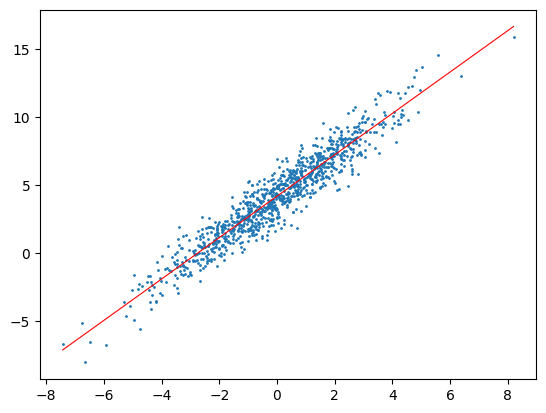

In [ ]:
def visualize_line(X, y, w):
    x_fit = np.linspace(X.min().item(), X.max().item(), 1000)
    y_fit = x_fit * w[1] + w[0] # line
    plt.scatter(X, y, 1)
    plt.plot(x_fit, y_fit, c = 'r', linewidth=0.8)
    plt.show()

visualize_line(X_train, y_train, w_norm_eq)

El error de entrenamiento es el siguiente:

In [ ]:
print("MSE de entrenamiento: ", mse(y_train_pred, y_train))

MSE de entrenamiento:  0.4703791763405322


#### Predicción para la data de prueba

Podemos hacer predicciones para la data de prueba, para ello primero debemos realizar todo tipo de preprocesamiento que se aplicó a la data de entrenamiento, en este caso se aumenta columan de unos. Luego se realizan las predicciones.

In [ ]:
# TODO: Adicionar columna de unos a la data de prueba
X_test_ones = add_intercept(X_test)

# TODO: Realizar predicciones usando los parámetros hallados
#       con la data de entrenamiento
y_test_pred = predict(X_test_ones, w_norm_eq)

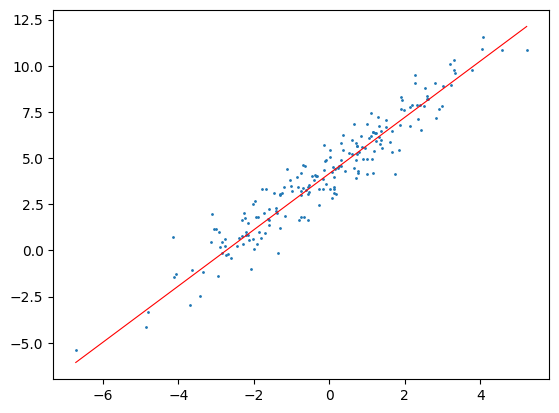

In [ ]:
visualize_line(X_test, y_test, w_norm_eq)

El error de prueba es el siguiente:

In [ ]:
print("MSE de prueba: ", mse(y_test_pred, y_test))

MSE de prueba:  0.500747389130181


## Regresión Lineal usando scikit-learn

Hasta este momento hemos realizado una implementación usando solamente operaciones sobre arreglos de Numpy. Sin embargo, scikit-learn ofrece una implementación de regresión lineal que facilitará todo el proceso.

### LinearRegression

LinearRegression es un modelo de regresión lineal proporcionado por la biblioteca scikit-learn en Python que utiliza una técnica similar a ecuaciones normales. Para usarlo es necesario importar el estimador [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

In [ ]:
from sklearn.linear_model import LinearRegression

Ahora inicializamos el modelo

In [ ]:
# Initializar LinearRegression
linear_regressor = LinearRegression()

Ahora entrenamos el modelo en la data de entrenamiento

In [ ]:
# Entrenar modelo
linear_regressor.fit(X_train, y_train)

Podemos acceder a los pesos luego de entrenar el modelo

In [ ]:
w_lr = linear_regressor.coef_
b_lr = linear_regressor.intercept_
print(f'Pesos: {w_lr}')
print(f'Intercept: {b_lr}')
# Mejores parámetros de solución analítica (Normal equations implementación desde 0):
#[[4.22797581]
# [1.50743282]]

Pesos: [[1.49160771]]
Intercept: [4.14628338]


### Predicciones de entrenamiento

In [ ]:
y_train_pred = linear_regressor.predict(X_train)

Visualizamos el modelo lineal en la data

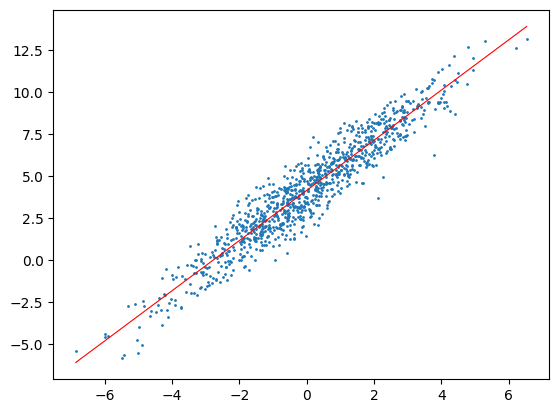

In [ ]:
visualize_line(X_train, y_train, np.array([b_lr, w_lr[0]]))

Obtenemos el error de entrenamiento

In [ ]:
print(f"MSE de entrenamiento: {mse(y_train, y_train_pred):.3f}")

MSE de entrenamiento: 0.470


### Predicciones en la data de prueba

In [ ]:
y_test_pred = linear_regressor.predict(X_test)

Visualizamos el modelo lineal en la data

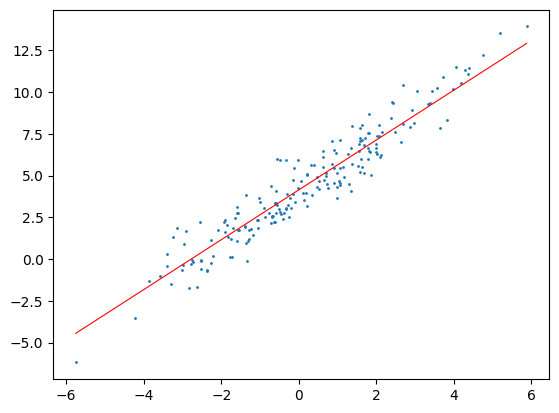

In [ ]:
visualize_line(X_test, y_test, np.array([b_lr, w_lr[0]]))

Obtenemos el error de prueba

In [ ]:
print(f"MSE de prueba: {mse(y_test, y_test_pred):.3f}")

MSE de entrenamiento: 0.501


# Ejercicios

## 1. Regresión usando el conjunto de datos de diabetes

Realice una regresión lineal con ecuaciones normales utilizando el conjunto de datos de diabetes de ``scikit-learn``. Utilizará scikit-learn solo para cargar el conjunto de datos y realizar cualquier preprocesamiento que considere conveniente. Puede utilizar el método ``train_test_split`` para dividir los datos. También puede utilizar ``LinearRegression()``.

Para calcular las métricas de regresión puede usar [mean squared error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) y otras métricas.

In [ ]:
from sklearn import datasets

# Conjunto de datos de diabetes
X, y = datasets.load_diabetes(return_X_y=True)

*Si lo cree conveniente puede implementar el ejercicio en otro notebook*

In [ ]:
from sklearn.datasets import load_diabetes

In [ ]:
diabetes = load_diabetes()


In [ ]:
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [ ]:
print(diabetes.data)

[[ 0.03807591  0.05068012  0.06169621 ... -0.00259226  0.01990749
  -0.01764613]
 [-0.00188202 -0.04464164 -0.05147406 ... -0.03949338 -0.06833155
  -0.09220405]
 [ 0.08529891  0.05068012  0.04445121 ... -0.00259226  0.00286131
  -0.02593034]
 ...
 [ 0.04170844  0.05068012 -0.01590626 ... -0.01107952 -0.04688253
   0.01549073]
 [-0.04547248 -0.04464164  0.03906215 ...  0.02655962  0.04452873
  -0.02593034]
 [-0.04547248 -0.04464164 -0.0730303  ... -0.03949338 -0.00422151
   0.00306441]]


## 2.